In [1]:
from UTILITY_quickstart import *

In [2]:
#Start from golden lattice
tao = initializeTao(
    loadDefaultLatticeTF = False
)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Base Tao lattice
WARNING! No beam file is specified!
Number of macro particles defined by input file


## Golden lattice

In [3]:
#The golden lattice linear optics gives 50 x 50 cm betas (zero alphas) at PENT
tao.ele_twiss("PENT")

{'mode_flip': False,
 'beta_a': 0.500113514905197,
 'alpha_a': -8.61413026751329e-05,
 'gamma_a': 1.99954605827816,
 'phi_a': 73.1003856252223,
 'eta_a': -4.29100544671707e-07,
 'etap_a': -7.60864677687215e-06,
 'beta_b': 0.499955681369933,
 'alpha_b': 0.000116201966385052,
 'gamma_b': 2.00017731724298,
 'phi_b': 60.4082301501082,
 'eta_b': -6.77061438266207e-18,
 'etap_b': -1.31862568529426e-17,
 'eta_x': -4.29100544671707e-07,
 'etap_x': -7.60864677687215e-06,
 'eta_y': -6.77059836943936e-18,
 'etap_y': -1.31862402801866e-17}

In [4]:
#At MFFF, have
#     Beta    Alpha
# x   11.55   -0.64
# y   25.2    -1.56
tao.ele_twiss("MFFF")

{'mode_flip': False,
 'beta_a': 11.5533562066008,
 'alpha_a': -0.64078864083071,
 'gamma_a': 0.122095264526835,
 'phi_a': 71.31011993097,
 'eta_a': 1.82993853116333e-05,
 'etap_a': 1.18535480249718e-06,
 'beta_b': 25.2039557159784,
 'alpha_b': -1.56858472563668,
 'gamma_b': 0.137298211459199,
 'phi_b': 56.2536406733655,
 'eta_b': -2.27197431822334e-17,
 'etap_b': -4.93465667198356e-20,
 'eta_x': 1.82993853116333e-05,
 'etap_x': 1.18535480249718e-06,
 'eta_y': -2.27197534407484e-17,
 'etap_y': -4.93522682312884e-20}

## Changing beam into BC20

In [5]:
#The last four quads before BC20 are:
quadNames = ["Q19701", "Q19801", "Q19851", "Q19871"] 

In [6]:
[getQuadkG(tao, name) for name in quadNames]

[-26.683429346055387, 35.70088204754025, -64.0952053793749, 44.93605802146798]

In [7]:
#Following code adapted from "2024-08-09 Second IP linear optics.ipynb"

In [8]:
# Limits and values as of 2025-01-07 
# SCP for for 701 and 801, EPICS for 851 and 871
pbounds = {
    'Q19701':  [-107.5, 0],   #BCON = -26.7
    'Q19801':  [0, 107.5],    #BCON = 35.7
    'Q19851':  [-101.9, 0],   #BCON = -64.1
    'Q19871':  [0, 101.9],    #BCON = 44.9
}

In [9]:
# setQuadkG(tao, 'Q19701', 100) 
# tao.ele_twiss("PENT")

In [10]:
def rampToZero(val, thresh, scale = 1):
    return (max(val, thresh) - thresh) / scale

def specificOptimizer(
    self,
    **kwargs
):

    self.totalNumEvals += 1
    self.displayEvals()

    savedData = kwargs
    
    badValue = -1e300  #The value returned for illegal config. Should be colossal. Double limit ~= 1e308
    bigCost  = 1e50   #Should be large enough to dominate any "normal" return value but be dominated by badValue
    
    try: #This try block deals with bad configurations. Instead of causing the optimizer to halt we now 'except' a low value
        #setLattice(tao, **kwargs)
        # setQuadkG(tao, 'Q19701', kwargs['Q19701'])
        # print(f"""kwargs['Q19701'] = {kwargs['Q19701']}""")
        for name in quadNames:
            setQuadkG(tao, name, kwargs[name])

    except:
        return badValue * 5

    
    try: 
        # transportMatrix = (tao.matrix("BEGBC20","PENT"))["mat6"]
        # savedData["R11"] = transportMatrix[0][0]
        # savedData["R12"] = transportMatrix[0][1]

        # savedData["R33"] = transportMatrix[2][2]
        # savedData["R34"] = transportMatrix[2][3]
        savedData["betaX"] = tao.ele_twiss("MFFF")["beta_a"]
        savedData["alphaX"] = tao.ele_twiss("MFFF")["alpha_a"]
        savedData["betaY"] = tao.ele_twiss("MFFF")["beta_b"]
        savedData["alphaY"] = tao.ele_twiss("MFFF")["alpha_b"]
        
        
            
    except:
        return badValue




    # savedData["maximizeMe"] = 1 / np.mean([
    #     #abs(1 - savedData["R11"]),
    #     abs(savedData["R12"]),
        
    #     #abs(1 - savedData["R33"]),
    #     #abs(1 - abs(savedData["R33"])),
    #     abs(savedData["R34"]),

    #     1e-20 #Prevent infinities
    # ])

    savedData["alphaPenalty"] = 1e9 * rampToZero(( abs(savedData["alphaX"]) + abs(savedData["alphaY"]) ), 1e-6)

    #Using product instead of sum causes it to prefer more symmetric solutions
    #savedData["maximizeMe"] = savedData["betaX"] + savedData["betaY"] - savedData["alphaPenalty"]
    #savedData["maximizeMe"] = savedData["betaX"] * savedData["betaY"] - (savedData["alphaPenalty"] ** 2)
    #savedData["maximizeMe"] = np.min([savedData["betaX"], savedData["betaY"]]) - (savedData["alphaPenalty"] ** 2)
    savedData["maximizeMe"] = 10 * np.min([savedData["betaX"], savedData["betaY"]]) + savedData["betaX"] + savedData["betaY"] - (savedData["alphaPenalty"] ** 2)
    
    

    
    #Collect desired data as a pandas Series
    tmpData = pd.Series( savedData ) 
    self.history = pd.concat([self.history, tmpData.to_frame().T])
    
    #Optional: Write to file
    #self.history.to_json('optimizerHistory.json', orient='records')
    n = self.totalNumEvals
    if (n < 100) or (n < 1000 and  n % 10 == 0) or (n % 100 == 0): #This gets expensive to write when n >> 10k
        self.history.to_json('optimizerHistory.json', orient='records')
    
    self.updatePlot()


    return savedData["maximizeMe"]




# Function to create optimizerWrapper based on pbounds
def create_optimizer_wrapper(pbounds):
    param_names = list(pbounds.keys())
    
    def optimizerWrapper(self, **kwargs):
        params = {name: kwargs.get(name, None) for name in param_names}
        if None in params.values():
            raise ValueError("All parameters must be provided")
        return specificOptimizer(self, **params)
    
    return optimizerWrapper

# Create the optimizerWrapper function
optimizerWrapper = create_optimizer_wrapper(pbounds)

In [11]:
class OptimizationProblem:
    def __init__(self):
        self.history = pd.DataFrame()
        self.totalNumEvals = 0
        self.plot_display_handle = None
        self.evals_display_handle = None


    def updatePlot(self):
        #This function seems to cause a substantial memory leak.
        #This hack below reduces the plotting frequency which makes it tolerable

        n = self.totalNumEvals
        
        if (n < 100) or (n < 1000 and  n % 10 == 0) or (n % 100 == 0): 
            plt.figure()
            plotKey = "maximizeMe"
            plt.plot(np.arange(len(self.history[plotKey])), self.history[plotKey], '-')
            
            plt.title('Optimization History')
            plt.xlabel('Evaluation #')
            plt.ylabel(plotKey)
            plt.yscale('log')
            plt.grid(True)
            
            
            if self.plot_display_handle is None:
                self.plot_display_handle = display(plt.gcf(), display_id=True)
            else:
                update_display(plt.gcf(), display_id=self.plot_display_handle.display_id)
            plt.close()

        return

    def displayEvals(self):
        if self.evals_display_handle is None:
            self.evals_display_handle = display(f"Total Num Evals: {self.totalNumEvals}", display_id=True)
        else:
            update_display(f"Total Num Evals: {self.totalNumEvals}", display_id=self.evals_display_handle.display_id)

# Attach the function to the class as a method
OptimizationProblem.optimizerWrapper = optimizerWrapper

# Instantiate the optimization problem
problem = OptimizationProblem()

In [12]:
from scipy.optimize import differential_evolution

# Convert pbounds to the format required by differential_evolution
bounds = [(low, high) for (low, high) in pbounds.values()]
param_names = list(pbounds.keys())

#scipy.optimize wants to optimize a function which is passed a vector of all the parameters
#This programmatically wraps the existing wrapper (ugh...) to handle this format
def create_DE_wrapper(obj, param_names):
    def wrapperDE(params):
        param_dict = dict(zip(param_names, params))

        #bayes_opt is a maximizer but differential_evolution is a minimizer... hence the inversion
        return -1*obj.optimizerWrapper(**param_dict)
    
    return wrapperDE

wrapperDE = create_DE_wrapper(problem, param_names)

In [13]:
#defaultSettingsVector = [getQuadkG(tao, name) for name in quadNames]
defaultSettingsVector = [-12.2977752909, 0.0984643843, -67.8496101619, 70.2991853958]

'Total Num Evals: 462'

/var/folders/3j/4b_6gm4j44z6mpdlh3f3ggjc0000gn/T/ipykernel_5049/1806273417.py:23: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


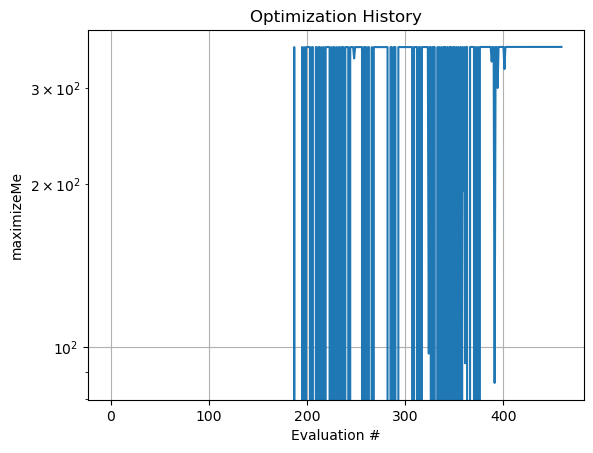

/var/folders/3j/4b_6gm4j44z6mpdlh3f3ggjc0000gn/T/ipykernel_5049/1806273417.py:23: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/var/folders/3j/4b_6gm4j44z6mpdlh3f3ggjc0000gn/T/ipykernel_5049/1806273417.py:23: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/var/folders/3j/4b_6gm4j44z6mpdlh3f3ggjc0000gn/T/ipykernel_5049/1806273417.py:23: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/var/folders/3j/4b_6gm4j44z6mpdlh3f3ggjc0000gn/T/ipykernel_5049/1806273417.py:23: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/var/folders/3j/4b_6gm4j44z6mpdlh3f3ggjc0000gn/T/ipykernel_5049/1806273417.py:23: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/var/folders/3j/4b_6gm4j44z6mpdlh3f3ggjc0000gn/T/ipykernel_5049/1806273417.py:23: UserWarning: Data 

       Q19701    Q19801     Q19851     Q19871      betaX        alphaX  \
0  -12.297775  0.098464 -67.849610  70.299185  29.772456 -8.785767e-04   
0  -12.912664  0.098464 -67.849610  70.299185  30.628851  1.834806e-02   
0  -12.297775  0.103388 -67.849610  70.299185  29.763338 -6.679501e-04   
0  -12.297775  0.098464 -71.242091  70.299185  35.492394 -3.425127e-01   
0  -12.297775  0.098464 -67.849610  73.814145  19.970245  5.969332e-01   
..        ...       ...        ...        ...        ...           ...   
0  -12.301810  0.100014 -67.851293  70.303107  29.765632  9.799786e-08   
0  -12.301839  0.100014 -67.851279  70.303096  29.765682  9.242195e-08   
0  -12.301780  0.100015 -67.851308  70.303117  29.765581  9.738833e-08   
0  -12.301774  0.100015 -67.851311  70.303119  29.765570  1.017093e-07   
0  -12.301781  0.100015 -67.851307  70.303117  29.765583  9.988246e-08   

        betaY        alphaY  alphaPenalty    maximizeMe  
0   29.772451 -1.165576e-04  9.941343e+05 -9.883030e+

In [14]:
#### #Optional: Define list of starting points
totalPopSize = 50  # Total population size
numDimensions = len(bounds)  # Number of parameters

# #Uniformly distributed
# populationDE = np.random.rand(totalPopSize, numDimensions)
# for i in range(numDimensions):
#     low, high = bounds[i]
#     populationDE[:, i] = low + populationDE[:, i] * (high - low)

#Normally distributed
populationDE = np.zeros((totalPopSize, numDimensions))
for i in range(numDimensions):
    low, high = bounds[i]

    #Define mean based on bounds
    #mean = (high + low) / 2

    #Optional: Define mean based on defaultSettingsVector
    mean = defaultSettingsVector[i]
    
    std_dev = (high - low) / 5
    populationDE[:, i] = np.random.normal(mean, std_dev, totalPopSize)

#Optional: Add specific points to initial evaluation list
#populationDE = np.vstack([[ np.mean(i) for i in bounds ], populationDE])
populationDE = np.vstack([[ defaultSettingsVector ], populationDE])

# result = differential_evolution(
#     wrapperDE, 
#     bounds,
#     maxiter=1000, 
#     disp=True,
#     polish = False, 
#     init = populationDE
# )

from scipy.optimize import minimize


#Optional: Manually define starting simplex
# initial_simplex = np.tile(defaultSettingsVector, (numDimensions + 1, 1))
# for i in range(1, numDimensions + 1):
#     initial_simplex[i][i - 1] *= 1.1

result = minimize(
    wrapperDE, 
    defaultSettingsVector,
    method = "Nelder-Mead",
    bounds = bounds,
    #options={'initial_simplex': initial_simplex}
    options = {'adaptive': True}
)

# result = minimize(
#     wrapperDE, 
#     defaultSettingsVector,
#     method = "L-BFGS-B",
#     bounds = bounds,
#     #options = {"eps": [0.001*x for x in defaultSettingsVector]}
#     options = {"eps": [0.1 for x in defaultSettingsVector]}
# )

# result = minimize(
#     wrapperDE, 
#     defaultSettingsVector,
#     method = "COBYQA",
#     bounds = bounds,
#     options = {
#         "scale": True, 
#         "initial_tr_radius": 1e-1, #1e-1
#         "final_tr_radius": 1e-8, 
#         "disp": True } #"*_tr_radius" appears to constrain the scaled, not raw, variables (if scaling is enabled)
# )

print(problem.history) 

## Results

In [21]:
# Q19701 : -12.3017801429
# Q19801 : 0.1000154885
# Q19851 : -67.8513077419
# Q19871 : 70.3031170057
# betaX : 29.7655811532
# alphaX : 9.74e-8
# betaY : 29.7656349098
# alphaY : 8.409e-7
# alphaPenalty : 0.
# maximizeMe : 357.1870275955

defaultSettingsVector = [-12.3017801429, 0.1000154885, -67.8513077419, 70.3031170057]

In [30]:
#Start from golden lattice
tao = initializeTao(
    loadDefaultLatticeTF = False
)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Base Tao lattice
WARNING! No beam file is specified!
Number of macro particles defined by input file


In [31]:
tao.ele_twiss("PENT")

{'mode_flip': False,
 'beta_a': 0.500113514905197,
 'alpha_a': -8.61413026751329e-05,
 'gamma_a': 1.99954605827816,
 'phi_a': 73.1003856252223,
 'eta_a': -4.29100544671707e-07,
 'etap_a': -7.60864677687215e-06,
 'beta_b': 0.499955681369933,
 'alpha_b': 0.000116201966385052,
 'gamma_b': 2.00017731724298,
 'phi_b': 60.4082301501082,
 'eta_b': -6.77061438266207e-18,
 'etap_b': -1.31862568529426e-17,
 'eta_x': -4.29100544671707e-07,
 'etap_x': -7.60864677687215e-06,
 'eta_y': -6.77059836943936e-18,
 'etap_y': -1.31862402801866e-17}

In [32]:
for i in range(4):
    setQuadkG(tao, quadNames[i], defaultSettingsVector[i])




setQuadkG(tao, "Q5FF", 0)
setQuadkG(tao, "Q4FF", 0)
setQuadkG(tao, "Q3FF", 0)
setQuadkG(tao, "Q2FF", 0)
setQuadkG(tao, "Q1FF", 0)
setQuadkG(tao, "Q0FF", 0)
setQuadkG(tao, "Q0D", 0)
setQuadkG(tao, "Q1D", 0)
setQuadkG(tao, "Q2D", 0)

In [33]:
tao.ele_twiss("PENT")

{'mode_flip': False,
 'beta_a': 62.1183955561056,
 'alpha_a': -2.56600115693764,
 'gamma_a': 0.122095264526835,
 'phi_a': 71.9394382055096,
 'eta_a': 3.69901994937505e-05,
 'etap_a': 1.18535480249718e-06,
 'beta_b': 108.80815352558,
 'alpha_b': -3.7335191001574,
 'gamma_b': 0.137298211459199,
 'phi_b': 56.5594895777048,
 'eta_b': -3.062786696503e-17,
 'etap_b': -4.93465667198356e-20,
 'eta_x': 3.69901994937505e-05,
 'etap_x': 1.18535480249718e-06,
 'eta_y': -3.06279671256493e-17,
 'etap_y': -4.93522682312884e-20}

In [34]:
tao.ele_twiss("MFFF")

{'mode_flip': False,
 'beta_a': 11.5533562066008,
 'alpha_a': -0.64078864083071,
 'gamma_a': 0.122095264526835,
 'phi_a': 71.31011993097,
 'eta_a': 1.82993853116333e-05,
 'etap_a': 1.18535480249718e-06,
 'beta_b': 25.2039557159784,
 'alpha_b': -1.56858472563668,
 'gamma_b': 0.137298211459199,
 'phi_b': 56.2536406733655,
 'eta_b': -2.27197431822334e-17,
 'etap_b': -4.93465667198356e-20,
 'eta_x': 1.82993853116333e-05,
 'etap_x': 1.18535480249718e-06,
 'eta_y': -2.27197534407484e-17,
 'etap_y': -4.93522682312884e-20}

In [35]:
getMatrix(tao,"MFFF","PENT",print = True);

1.000000,15.768118,0.000000,0.000000,0.000000,-0.000000
0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
0.000000,0.000000,1.000000,15.768118,0.000000,-0.000000
0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
0.000000,-0.000000,0.000000,-0.000000,1.000000,0.000000
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
